In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr_bias import FcIPLLRBias
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.ranks import *
from utils.nn import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Load basic configuration and define variables 

In [6]:
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 50
tol = 1.0e-8
activation = 'relu'
init_mean = 1.0

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [7]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = activation
config_dict['initializer']['params']["mean"] = init_mean
        
base_model_config = ModelConfig(config_dict)
base_model_config.scheduler = None

### Load data & define model

In [8]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [9]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)

## Define model

In [10]:
ip_non_centered = StandardFCIP(base_model_config)

In [11]:
for i, param_group in enumerate(ip_non_centered.optimizer.param_groups):
    if i == 0:
        param_group['lr'] = param_group['lr'] * (ip_non_centered.d + 1)

## Save initial model

In [12]:
ip_non_centered_0 = deepcopy(ip_non_centered)

### Train model one step : t=1

In [13]:
x, y = batches[0]

train_model_one_step(ip_non_centered, x, y, normalize_first=True)
ip_non_centered_1 = deepcopy(ip_non_centered)

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.8973,  0.1012,  0.1034,  ...,  0.0987,  0.1016,  0.0987],
        [ 0.1028, -0.8988,  0.1035,  ...,  0.0987,  0.1017,  0.0987],
        [ 0.1026,  0.1012,  0.1033,  ...,  0.0988,  0.1016, -0.9012],
        ...,
        [ 0.1029,  0.1013,  0.1036,  ...,  0.0987,  0.1017, -0.9014],
        [ 0.1026,  0.1012,  0.1033,  ...,  0.0988,  0.1016,  0.0988],
        [ 0.1031,  0.1014,  0.1039,  ...,  0.0986, -0.8981,  0.0985]])
average training loss for model1 : 2.302236557006836



### Train model for a second step : t=2

In [14]:
x, y = batches[1]

train_model_one_step(ip_non_centered, x, y, normalize_first=True)
ip_non_centered_2 = deepcopy(ip_non_centered)

input abs mean in training:  0.6921874284744263
loss derivatives for model: tensor([[ 0.1019,  0.1010,  0.1026,  ...,  0.0990, -0.8986,  0.0991],
        [ 0.1027,  0.1014,  0.1036,  ...,  0.0986,  0.1019,  0.0987],
        [ 0.1022,  0.1012,  0.1030,  ...,  0.0988,  0.1016,  0.0989],
        ...,
        [ 0.1023,  0.1012,  0.1031,  ...,  0.0988,  0.1016,  0.0989],
        [ 0.1020, -0.8989,  0.1027,  ...,  0.0990,  0.1014,  0.0990],
        [ 0.1027,  0.1014,  0.1036,  ...,  0.0986, -0.8981,  0.0987]])
average training loss for model1 : 2.3003787994384766



In [15]:
ip_non_centered.eval()
ip_non_centered_0.eval()
ip_non_centered_1.eval()
ip_non_centered_2.eval()
print('')

In [16]:
layer_scales = ip_non_centered.layer_scales
intermediate_layer_keys = ["layer_{:,}_intermediate".format(l) for l in range(2, L + 1)]

### Define W0 and b0

In [17]:
W0, b0 = get_W0_dict(ip_non_centered_0, normalize_first=True) 

### Define Delta_W_1 and Delta_b_1

In [18]:
Delta_W_1, Delta_b_1 = get_Delta_W1_dict(ip_non_centered_0, ip_non_centered_1, normalize_first=True)

### Define Delta_W_2 and Delta_b_2

In [19]:
Delta_W_2, Delta_b_2 = get_Delta_W2_dict(ip_non_centered_1, ip_non_centered_2, normalize_first=True)

## Explore at step 1

### On all training samples

In [20]:
x, y = full_x, full_y

In [21]:
h0, delta_h_1, h1, x1 = get_contributions_1(x, ip_non_centered_1, W0, b0, Delta_W_1, Delta_b_1, 
                                            normalize_first=True)

### Contributions of the different terms

In [22]:
columns = ['h0', 'delta_h_1', 'h1', 'x1']
df = pd.DataFrame(columns=columns, index=range(1, L+1))
for l in df.index:
    df.loc[l, columns] = [h0[l].abs().mean().item(), delta_h_1[l].abs().mean().item(), h1[l].abs().mean().item(),
                          x1[l].abs().mean().item()]
df

,h0,delta_h_1,h1,x1
1,1.11228,0.0491297,1.11484,0.575076
2,0.573939,5.724e-05,0.573969,0.573969
3,0.573184,9.15499e-06,0.573193,0.573193
4,0.573685,9.09831e-06,0.573694,0.573694
5,0.574595,4.81162e-05,0.574604,0.574604
6,0.575746,0.00109424,0.575754,0.575754


## Ranks after one step

### Rank of the initial weights and first two updates 

In [23]:
weight_ranks_dfs_dict = dict()

tol = None
weight_ranks_dfs_dict['svd_default'] = get_svd_ranks_weights(W0, Delta_W_1, Delta_W_2, L, tol=tol)

tol = 1e-7
weight_ranks_dfs_dict['svd_tol'] = get_svd_ranks_weights(W0, Delta_W_1, Delta_W_2, L, tol=tol)

weight_ranks_dfs_dict['squared_tr'] = get_square_trace_ranks_weights(W0, Delta_W_1, Delta_W_2, L)

In [24]:
weight_ranks_dfs_dict['svd_default']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,784,425,427,784
2,2,1022,1,1,1024
3,3,1023,9,2,1024
4,4,1022,162,2,1024
5,5,1022,4,1,1024
6,6,1022,1,1,1024
7,7,10,1,1,10


In [25]:
weight_ranks_dfs_dict['svd_tol']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,784,514,514,784
2,2,1024,1,1,1024
3,3,1024,2,1,1024
4,4,1024,2,1,1024
5,5,1024,1,1,1024
6,6,1024,1,1,1024
7,7,10,1,1,10


In [26]:
weight_ranks_dfs_dict['squared_tr']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,444.245,1.6606,1.54178,784
2,2,8.90331,2.03859e-05,4.44269e-05,1024
3,3,8.8898,2.84339e-10,1.69622e-06,1024
4,4,8.83214,7.47819e-11,1.65695e-06,1024
5,5,8.82442,1.25744e-07,3.21675e-06,1024
6,6,8.8334,0.0308296,0.0646727,1024
7,7,3.07954,2.77591e-08,6.32905e-08,10


In [27]:
ranks_dfs = [weight_ranks_dfs_dict['svd_default'],
             weight_ranks_dfs_dict['svd_tol'],
             weight_ranks_dfs_dict['squared_tr']]

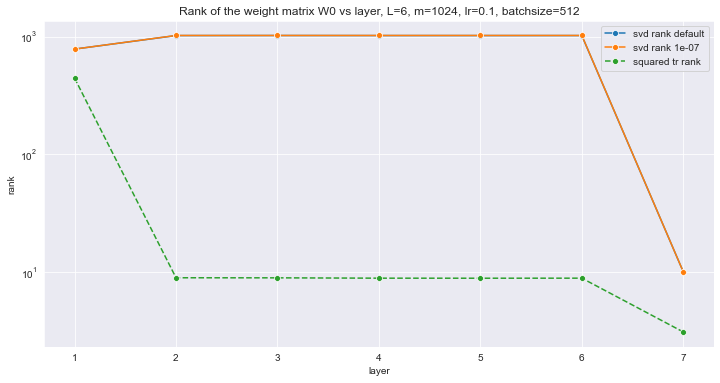

In [28]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('W0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

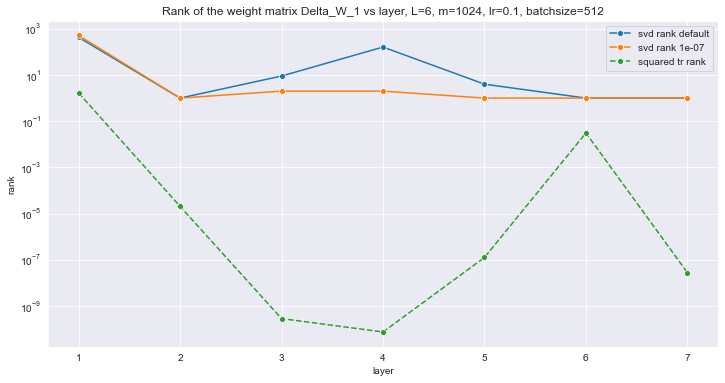

In [29]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

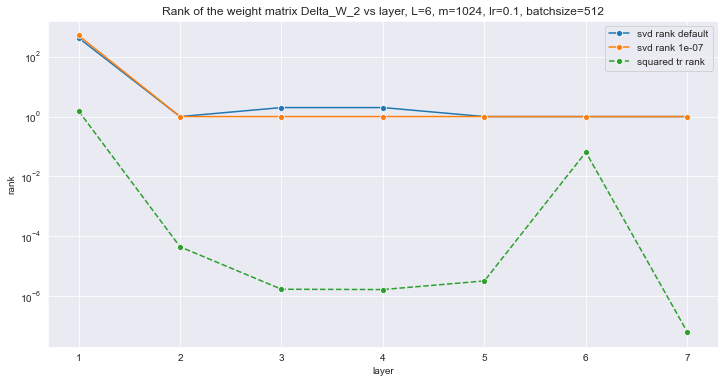

In [30]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_2', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

#### Ranks of the pre-activations

In [31]:
act_ranks_df_dict = dict()

tol = None
act_ranks_df_dict['svd_default'] = get_svd_ranks_acts(h0, delta_h_1, h1, x1, L, tol=tol) 

tol = 1e-7
act_ranks_df_dict['svd_tol'] = get_svd_ranks_acts(h0, delta_h_1, h1, x1, L, tol=tol)

act_ranks_df_dict['squared_tr'] = get_square_trace_ranks_acts(h0, delta_h_1, h1, x1, L)

In [32]:
act_ranks_df_dict['svd_default']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,432,24,431,955,1024
2,2,13,1,13,13,1024
3,3,1,1,1,1,1024
4,4,1,1,1,1,1024
5,5,1,1,1,1,1024
6,6,1,1,1,1,1024
7,7,1,1,1,1,10


In [33]:
act_ranks_df_dict['svd_tol']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,1024,1024,1024,1024,1024
2,2,1024,402,1024,1024,1024
3,3,1024,9,1024,1024,1024
4,4,1024,2,1024,1024,1024
5,5,1024,4,1024,1024,1024
6,6,1024,84,1024,1024,1024
7,7,10,2,10,10,10


In [34]:
act_ranks_df_dict['squared_tr']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,8.68275,2.06717,8.57477,3.90525,1024
2,2,1.00601,1,1.00601,1.00601,1024
3,3,1.00001,0.999965,1.00001,1.00001,1024
4,4,1,0.999969,1,1,1024
5,5,1,1,1,1,1024
6,6,1,1,1,1,1024
7,7,1,1,1,1,10


In [35]:
ranks_dfs = [act_ranks_df_dict['svd_default'],
             act_ranks_df_dict['svd_tol'],
             act_ranks_df_dict['squared_tr']]

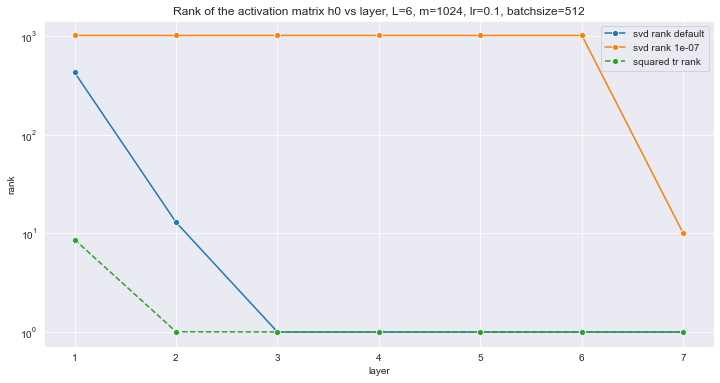

In [36]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

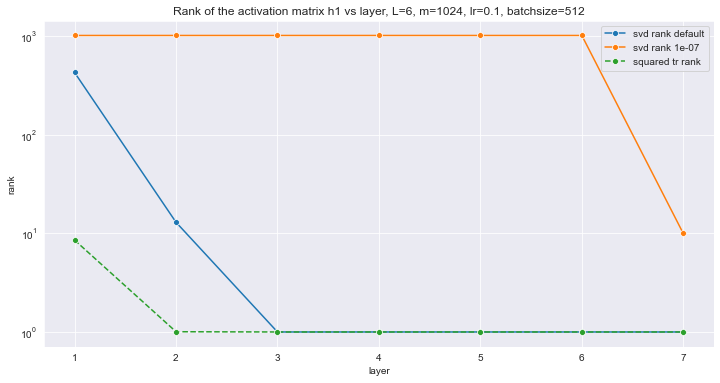

In [37]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

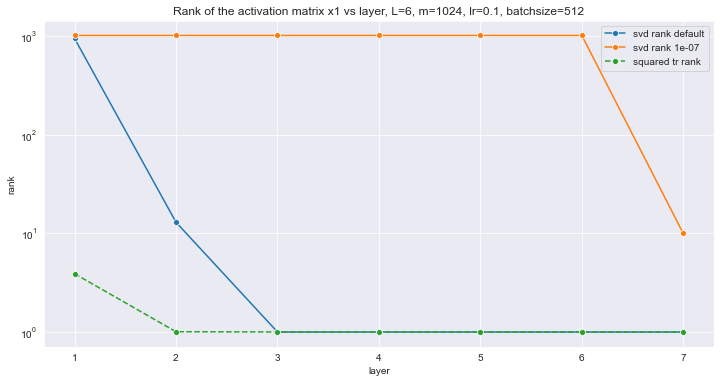

In [38]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('x1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

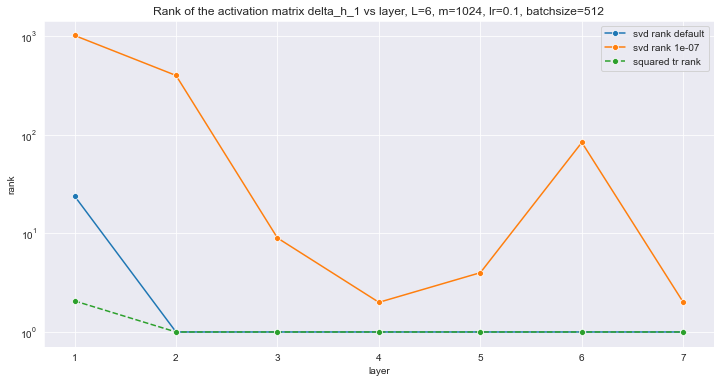

In [39]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('delta_h_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

### Diversity in terms of position of the maximum index

In [40]:
max_acts_diversity_df = get_max_acts_diversity(h0, delta_h_1, h1, L)

In [41]:
max_acts_diversity_df

,layer,h0,delta_h_1,h1,max
layer,,,,,
1,1,716,25,713,60000
2,2,405,36,405,60000
3,3,2,1,2,60000
4,4,1,1,1,60000
5,5,1,1,1,60000
6,6,1,1,1,60000
7,7,1,1,1,60000
